<h3> CV Assignment </h3>
<h4> In this project, I've implemented a binary classifier and a bidirectional LSTM network. The dataset used consists of various tweets.</h4> 

In [1]:
# packages rerquired for data preprocessing and representation
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
# packages required for building the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding 
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
# package required for computation of metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score, f1_score

In [2]:
# reading the given dataset
df = pd.read_csv('CVAssignmentDataset.csv')
df.dropna(axis = 0, inplace = True)
df.head()

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...


<h3>The following code blocks contain codes which are used for Exploratory Data Analysis<h3>

In [3]:
df.shape

(86460, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86460 entries, 0 to 86460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   86460 non-null  object
 1   Text    86460 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


<function matplotlib.pyplot.show(close=None, block=None)>

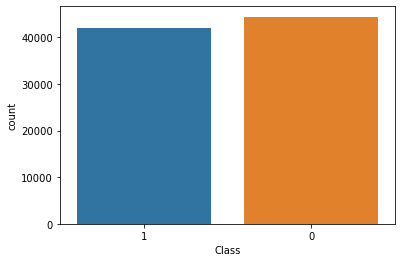

In [5]:
sns.countplot(x='Class', data = df)
plt.show

In [6]:
df['Class'].value_counts()

0    44392
1    42068
Name: Class, dtype: int64

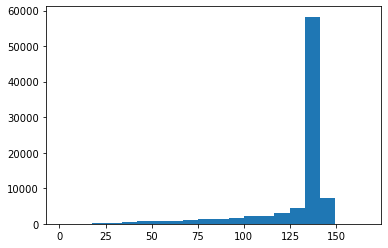

In [7]:
length = df['Text'].str.len()
plt.hist(length, bins=20, label="none")
plt.show()

<h3>Conclusions</h3>
<br>
Total number of rows = 86460 <br>
Number of values under class 0 : 44392 <br>
Number of values under class 1 : 42068

<h3>The data preprocessing phase begins now</h3>

In [8]:
#converting entries under 'Text' to string type
df['Text']=df['Text'].apply(str)

In [9]:
# function used to remove unwanted text patterns
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text
df['processed_tweet'] = np.vectorize(remove_pattern)(df['Text'], "@[\w]*") #removing special characters(except #)

In [10]:
df['processed_tweet'] = df['processed_tweet'].str.replace("[^a-zA-Z#]", " ") #removing everything except alphabets and #
df['processed_tweet'] = df['processed_tweet'].str.replace(r'http\S+', " ") #removing links
# removing words of shorter length
df['processed_tweet'] = df['processed_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) 

<ipython-input-10-1b3ca29d3fbe>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_tweet'] = df['processed_tweet'].str.replace("[^a-zA-Z#]", " ") #removing everything except alphabets and #
<ipython-input-10-1b3ca29d3fbe>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_tweet'] = df['processed_tweet'].str.replace(r'http\S+', " ") #removing links


In [11]:
# packages required for further data preprocessing
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Let's have a look at the processed data till now
df['processed_tweet'].head()

0    Today Senate Dems vote #SaveTheInternet Proud ...
1    Winter Haven resident Alta Vista teacher sever...
2    noted that Hurricane Maria left approximately ...
3    Meeting with Thanks taking time meet with Maru...
4    Hurricane season starts June Puerto Rico readi...
Name: processed_tweet, dtype: object

In [13]:
# converting the processed_tweet column in  pandas to a numpy array
dataArray = df.processed_tweet.to_numpy()
dataList = []
lemma = nltk.WordNetLemmatizer()

for data in dataArray:
    data = data.lower() 
    data = nltk.word_tokenize(data)
    #removal of stop-words(here stopwords.words('english') contains a set of frequently appearing stop words.
    stop_words = set(stopwords.words('english')) 
    data = [w for w in data if not w in stop_words]
    data = [lemma.lemmatize(word) for word in data] #Lemmatizing(removing inflectional endings and returning the base forms of words)
    data = " ".join(data)
    dataList.append(data)


dataArray = np.asarray(dataList) #updating dataArray with the obtained list
df['processed_tweet'] = dataArray
df['processed_tweet']

0        today senate dems vote # savetheinternet proud...
1        winter resident alta vista teacher several rec...
2        noted hurricane maria left approximately billi...
3        meeting thanks taking time meet marucci guzman...
4        hurricane season start june puerto rico readin...
                               ...                        
86456    check need executive overreach white house cri...
86457    yesterday betty great time learning forestry i...
86458    forever grateful service sacrifice major barne...
86459                happy first school # cobbbacktoschool
86460    # zika fear realized florida house acted preve...
Name: processed_tweet, Length: 86460, dtype: object

In [14]:
# tokenizing the processed words using TweetTokenizer
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True)

df['processed_tweet'] = df.processed_tweet.apply(tokenizer.tokenize)

# converting the tokens to frequency distribution rankings
topWords = 10000 # chosen as given in the problem statement 
freq_dist = FreqDist(w for t in df.processed_tweet for w in t)
tweetTerms = [te for te, cnt in freq_dist.most_common(topWords)]
df.processed_tweet = df.processed_tweet.apply(lambda tweet:[tweetTerms.index(te) if te in tweetTerms else 0 for te in tweet])

In [15]:
# Let's now have a look at the tokenized and ranked dataset
df.processed_tweet

0        [1, 121, 851, 55, 0, 2130, 22, 21, 2205, 0, 48...
1          [1469, 347, 0, 3600, 199, 705, 964, 33, 199, 0]
2        [6084, 544, 1969, 597, 3816, 219, 1035, 12, 7499]
3                       [37, 17, 216, 10, 101, 0, 0, 0, 0]
4               [544, 694, 257, 1706, 730, 836, 1396, 253]
                               ...                        
86456           [168, 18, 796, 4302, 282, 5, 6297, 110, 0]
86457    [73, 5259, 2, 10, 1039, 6027, 420, 1617, 4966,...
86458                      [1458, 326, 45, 490, 495, 0, 0]
86459                                   [28, 32, 25, 0, 0]
86460    [0, 3114, 1352, 5907, 379, 5, 2766, 484, 212, ...
Name: processed_tweet, Length: 86460, dtype: object

In [16]:
# padding is done to bring the processed dataset to a length of 50, as given in the problem statement
x = df.processed_tweet
ipLength = 50
x = sequence.pad_sequences(x, maxlen = ipLength)
print(x.shape)

# here the dataset is assigned to a variable x, which will be further used for training and testing.

(86460, 50)


In [17]:
# This is how our dataset(with values) looks like, after padding
df.processed_tweet

0        [1, 121, 851, 55, 0, 2130, 22, 21, 2205, 0, 48...
1          [1469, 347, 0, 3600, 199, 705, 964, 33, 199, 0]
2        [6084, 544, 1969, 597, 3816, 219, 1035, 12, 7499]
3                       [37, 17, 216, 10, 101, 0, 0, 0, 0]
4               [544, 694, 257, 1706, 730, 836, 1396, 253]
                               ...                        
86456           [168, 18, 796, 4302, 282, 5, 6297, 110, 0]
86457    [73, 5259, 2, 10, 1039, 6027, 420, 1617, 4966,...
86458                      [1458, 326, 45, 490, 495, 0, 0]
86459                                   [28, 32, 25, 0, 0]
86460    [0, 3114, 1352, 5907, 379, 5, 2766, 484, 212, ...
Name: processed_tweet, Length: 86460, dtype: object

In [18]:
# now the labels are assigned to a variable y
y = df.Class

In [19]:
# splitting the pre-processed data into training and testing datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

In [20]:
# converting the splitted data into arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# type conversion to float
x_train = x_train.astype(float)
y_train = y_train.astype(float)
x_test = x_test.astype(float)
y_test = y_test.astype(float)

In [21]:
#creating the model as given in the model architecture image in the problem statement
def baseline_model():
    
    model = Sequential() # one input tensor and one output tensor
    embeddingVectorLength = 32 # assigned as given in the image
    
    model.add(layers.Input(shape = ipLength, dtype='float64')) # first layer(input)
    model.add(Embedding(topWords, embeddingVectorLength, input_length = ipLength))
    
    model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) #kernel size is chosen as 3 pertaining to normal convention
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(256)))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [22]:
# let's run the summary of the model, and start training
model = baseline_model()
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=64, validation_split=0.33, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           591872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

<br>
<p> After multiple trials, the number of epochs is chosen to be 3 and validation_split is assigned a value of 0.33(pertaining to standard convention). After observing the increase in accuracy and reduction in loss, it is inferred that the model works fine. It is also noted that the validation loss increases, over the epochs. It was observed that for more number of epochs, the validation loss fluctuates (i.e) reduces and later increases which is an indication of overfitting. This is a common phenomenon, observed in many models. Hence to avoid that, the number of epochs is reduced to 3 and the test_size is also reduced. This leads to increased accuracy of predicted values and lesser chances of overfitting </p>

In [26]:
y_pred = model.predict(x_test, use_multiprocessing=True)
print('Accuracy {}'.format(accuracy_score(y_test, np.round(y_pred))))
print('Confusion Matrix {}'.format(confusion_matrix(y_test, np.round(y_pred))))
print('Matthews Correlation Coefficient {}'.format(matthews_corrcoef(y_test, np.round(y_pred))))

Accuracy 0.7313439740920656
Confusion Matrix [[8525 2507]
 [3300 7283]]
Matthews Correlation Coefficient 0.46288772322516836


In [27]:
print('F1 score {}'.format(f1_score(y_test, np.round(y_pred))))

F1 score 0.7149658862219603


By observing the results of the metrics, we infer that the model is now predicting values with an accuracy of 0.7313 and with an MCC value of 0.4628. By looking at the Confusion Matrix, the combined values of FP and FN is lesser than that of TP and TN, which indicates that the model predicts majority of the values correctly. Also the F1 score turns out to be 0.7149, which is also an indication of fine working of the model.